## LLM based image understanding 
#### Contributor(s): Utkarsh Pratiush <utkarshp1161@gmail.com> - 20th April 2025
#### edited - 
   

In [1]:
from stemOrchestrator.logging_config import setup_logging

data_folder = "."
out_path = data_folder
setup_logging(out_path=out_path)
from stemOrchestrator.acquisition import TFacquisition, DMacquisition
from stemOrchestrator.simulation import DMtwin
from stemOrchestrator.process import HAADF_tiff_to_png, tiff_to_png
from autoscript_tem_microscope_client import TemMicroscopeClient
import matplotlib.pyplot as plt
import logging

plot = plt
from typing import Dict

In [2]:
import os
import json
from pathlib import Path

# ip = "10.46.217.241"
# port = 9095

ip = "10.46.217.242"
port = 9090


# if not ip or not port:
#     secret_path = Path("../config_secret.json")
#     if secret_path.exists():
#         with open(secret_path, "r") as f:
#             secret = json.load(f)
#             ip = ip or secret.get("ip_TF")
#             port = port or secret.get("port_TF")


config = {
    "ip": ip,
    "port": port,
    "haadf_exposure": 10e-6,  # micro-seconds per pixel
    "haadf_resolution": 512,  # square
    "out_path": ".",
}

In [3]:
ip = config["ip"]
port = config["port"]
haadf_exposure = config["haadf_exposure"]
out_path = config["out_path"]
haadf_resolution = config["haadf_resolution"]


microscope = TemMicroscopeClient()
microscope.connect(ip, port=port)  # 7521 on velox  computer
# microscope.connect( port = port)# 7521 on velox  computer

# query state:

tf_acquisition = TFacquisition(microscope=microscope)

# put beam shift to 0,0
# tf_acquisition.move_beam_shift_positon([0, 0])

Client connecting to [10.46.217.242:9090]...
Client connected to [10.46.217.242:9090]
2025-10-18 16:26:14,393 - INFO - Starting microscope initialization...
2025-10-18 16:26:14,396 - INFO - CETA camera initialized
2025-10-18 16:26:14,399 - INFO - HAADF detector initialized
2025-10-18 16:26:14,402 - INFO - Microscope initialization completed successfully


2025-10-18 16:17:44,662 - INFO - Acquiring HAADF image.
2025-10-18 16:17:44,663 - INFO - Performing beam UNblanking (old method)
The function 'unblank' is deprecated and will be removed in version 1.21
2025-10-18 16:17:44,665 - INFO - DONE -- beam UNblanking
2025-10-18 16:17:44,731 - INFO - Performing beam blanking (old method)
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-18 16:17:44,733 - INFO - DONE -- beam blanking
2025-10-18 16:17:44,744 - INFO - saving HAADF image as TF which has all the metadata..also returning an array
2025-10-18 16:17:44,744 - INFO - Done: Acquiring HAADF image - beam is blanked after acquisition - HAADF det is inserted


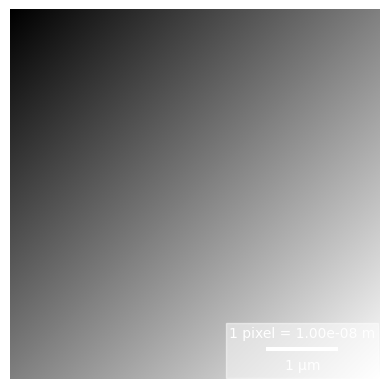

In [ ]:
# collecting haadf
haadf_np_array, haadf_tiff_name = tf_acquisition.acquire_haadf(
    exposure=10e-6, resolution=512
)
HAADF_tiff_to_png(haadf_tiff_name, save_png=True)

png_path = haadf_tiff_name.replace(".tiff", ".png")

2025-10-18 16:26:23,346 - INFO - Acquiring ceta image.
2025-10-18 16:26:23,346 - INFO - Performing beam UNblanking (old method)
The function 'unblank' is deprecated and will be removed in version 1.21
2025-10-18 16:26:23,350 - INFO - DONE -- beam UNblanking
2025-10-18 16:26:23,443 - INFO - Performing beam blanking (old method)
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-18 16:26:23,448 - INFO - DONE -- beam blanking
2025-10-18 16:26:23,668 - INFO - Saved ceta image with metadata to ceta_image_20251018_162623.tiff


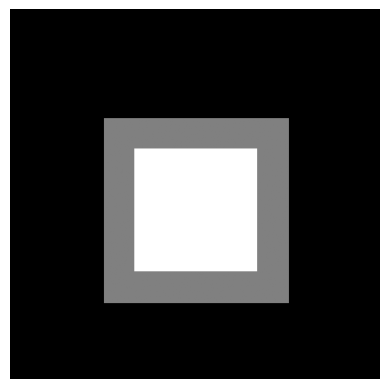

In [ ]:
# collecting diffraction
ceta_cp_array, ceta_tiff_name = tf_acquisition.acquire_ceta_or_flucam(
    exposure=0.1, resolution=512, camera="ceta"
)
# HAADF_tiff_to_png(ceta_tiff_name, save_png=True)
tiff_to_png(ceta_tiff_name, save_png=True)

png_path = ceta_tiff_name.replace(".tiff", ".png")

In [ ]:
import xmltodict
import json
from autoscript_tem_microscope_client.structures import EdsAcquisitionSettings
from autoscript_tem_microscope_client.enumerations import (
    EdsDetectorType,
    ExposureTimeType,
)
import numpy as np


def get_channel_index(energy_keV: float, dispersion: float, offset: float) -> int:
    """Convert energy (keV) into spectrum channel index."""
    return int(round((energy_keV - offset) / dispersion))


def get_dispersion_and_offset(spectrum):
    """
    Extract dispersion and offset from EDS spectrum metadata (xml).
    Returns (dispersion_keV_per_ch, offset_keV).
    """
    xml_string = spectrum.metadata.metadata_as_xml
    metadata = xmltodict.parse(xml_string)
    metadata = json.loads(json.dumps(metadata))

    detectors = metadata["Metadata"]["Detectors"]["AnalyticalDetector"]

    # If only one detector, wrap it into a list
    if isinstance(detectors, dict):
        detectors = [detectors]

    # Take the first detector (or filter by name if needed)
    det = detectors[0]
    dispersion = float(det.get("Dispersion", 0))
    offset = float(det.get("OffsetEnergy", 0))

    return dispersion, offset


def configure_acquisition(exposure_time=2):
    """Configure the EDS acquisition settings."""
    # mic_server is global variable intriduced in def run function
    eds_detector_name = microscope.detectors.eds_detectors[0]
    eds_detector = microscope.detectors.get_eds_detector(eds_detector_name)
    # Configure the acquisition
    global eds_settings
    eds_settings = EdsAcquisitionSettings()
    eds_settings.eds_detector = eds_detector_name
    eds_settings.dispersion = eds_detector.dispersions[-1]  # 20 keV
    eds_settings.shaping_time = eds_detector.shaping_times[-1]
    eds_settings.exposure_time = exposure_time
    eds_settings.exposure_time_type = ExposureTimeType.LIVE_TIME
    return eds_settings


# collecting edx


edx_exposure = 1  # in seconds
eds_settings = configure_acquisition(exposure_time=edx_exposure)

microscope.optics.unblank()
spectrum = microscope.analysis.eds.acquire_spectrum(eds_settings)
microscope.optics.blank()


## plotting the spectrum
# Average spectrum data from 4 detectors
n_channels_per_detector = len(spectrum.data) // 4
summed_spectrum = np.zeros(n_channels_per_detector)

for i in range(4):
    start_idx = i * n_channels_per_detector
    end_idx = (i + 1) * n_channels_per_detector
    summed_spectrum += spectrum.data[start_idx:end_idx]

# Use summed spectrum for analysis
spectrum_data = summed_spectrum

# Plot spectrum using matplotlib instead of vision_toolkit
dispersion, offset = get_dispersion_and_offset(spectrum)
energy_axis = (
    np.arange(len(spectrum_data)) * dispersion + offset
) / 1000  # 1000 for Kev

plt.figure(figsize=(12, 6))
plt.plot(energy_axis, spectrum_data)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("EDS Spectrum (Summed from 4 Detectors)")
plt.xlim(0, 20)  # Focus on physically relevant energy range
plt.savefig("edx.png")

In [7]:
import yaml
from stemOrchestrator.MLlayer.MLlayerLLM import generate_stem_analysis

# Load the YAML file
with open("credential.yaml", "r") as f:
    cred = yaml.safe_load(f)

GEMINI_API_KEY = cred["GEMINI-API-KEY"]

In [8]:
file_path = png_path
prompt = "Tell me about this image"

response_text = generate_stem_analysis(file_path, prompt, api_key=GEMINI_API_KEY)
print(response_text)

2025-10-18 16:19:10,794 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/upload/v1beta/files "HTTP/1.1 200 OK"
2025-10-18 16:19:11,844 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/upload/v1beta/files?upload_id=AAwnv3KlfHAZgON6MErZ2a9-JN9CE4tUHCRArT3fDjgrEn3r1v2_FDk1wI6Em9peQ9jzXRxHfxykfdieZYJsH5vNf2W3-noI-1CWVcxQrmFb9ys&upload_protocol=resumable "HTTP/1.1 200 OK"
2025-10-18 16:19:11,846 - INFO - AFC is enabled with max remote calls: 10.
2025-10-18 16:19:13,729 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash-exp-image-generation:generateContent "HTTP/1.1 200 OK"
Here's a description of the image:

*   **Content:** The image shows a grayscale gradient, transitioning from darker shades in the top-left corner to lighter shades towards the bottom-right.

*   **Scale Information:** In the bottom-right corner, there's information about the image scale.
    *   It states "1 pixel = 1.00e-08 m" (w

In [ ]:
file_path = png_path
prompt = "This is a scanning transmission electron HAADF image of SrTiO3 sample. Guess the direction of view.. also return an image making a square on it to highlight the unit cell"

response_text = generate_stem_analysis(file_path, prompt, api_key=GEMINI_API_KEY)
print(response_text)